In [7]:
import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

ImportError: cannot import name 'clip_to_image_size' from 'keras.src.layers.preprocessing.image_preprocessing.bounding_boxes.converters' (C:\Users\wimmu\anaconda3\envs\Neuroverkot\Lib\site-packages\keras\src\layers\preprocessing\image_preprocessing\bounding_boxes\converters.py)

Käytä esikoulutettua mallia (esim. VGG16) piirteiden irrottamiseen
Kouluta vain oma luokittelija (fully connected) irrotettujen piirteiden päälle
Vertaa suorituskykyä ensimmäiseen malliin

In [10]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])
train_dataset = image_dataset_from_directory("kuvat/train", image_size=(224, 224), batch_size=32)
validation_dataset = image_dataset_from_directory("kuvat/validation", image_size=(224, 224), batch_size=32)
test_dataset = image_dataset_from_directory("kuvat/test", image_size=(224, 224), batch_size=32)


train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

conv_base = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_base.summary()

Found 126 files belonging to 3 classes.
Found 27 files belonging to 3 classes.
Found 27 files belonging to 3 classes.


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
@tf.function(reduce_retracing=True)
def extract_features(images):
    return conv_base(images)

def get_features_and_labels(dataset):
    all_features, all_labels = [], []
    for images, labels in dataset:
        if labels is None:
            continue
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = extract_features(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return tf.concat(all_features, axis=0), tf.concat(all_labels, axis=0)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)


In [12]:
inputs = keras.Input(shape=(7, 7, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="feature_extraction.keras", save_best_only=True, monitor="val_loss")]

start_time = time.time()

history = model.fit(train_features, train_labels, epochs=20, validation_data=(val_features, val_labels), callbacks=callbacks, verbose=1)

training_time = time.time() - start_time

test_loss, test_acc = model.evaluate(test_features, test_labels)

# Save results
np.savez("VGG_kuvantunnistus_results.npz",
         test_acc=test_acc,
         test_loss=test_loss,
         training_time=training_time,
         history=history.history)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.2579 - loss: 46.5663 - val_accuracy: 0.4815 - val_loss: 27.0787
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.5881 - loss: 12.8304 - val_accuracy: 0.4444 - val_loss: 13.9435
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.8470 - loss: 3.5202 - val_accuracy: 0.5926 - val_loss: 10.5882
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.8584 - loss: 1.8323 - val_accuracy: 0.3704 - val_loss: 10.2993
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.8879 - loss: 1.6452 - val_accuracy: 0.4815 - val_loss: 7.1774
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.9539 - loss: 0.3241 - val_accuracy: 0.5556 - val_loss: 4.7434
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.9340 - loss: 0.2657 - val_accuracy: 0.6667 - val_loss: 3.4555
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.9497 - loss: 0.1177 - val_accuracy: 0.6667 - val

In [15]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8148 - loss: 1.2279
Test accuracy: 0.815


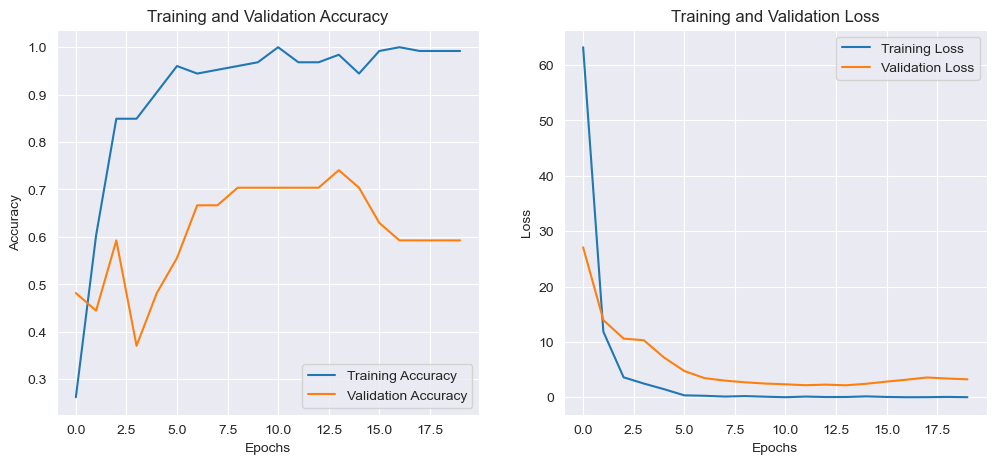

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
              precision    recall  f1-score   support

    haarukka       0.69      1.00      0.82         9
     lusikka       1.00      0.67      0.80         9
      veitsi       0.88      0.78      0.82         9

    accuracy                           0.81        27
   macro avg       0.86      0.81      0.81        27
weighted avg       0.86      0.81      0.81        27



In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

y_pred = np.argmax(model.predict(test_features), axis=1)
print(classification_report(test_labels, y_pred, target_names=['haarukka', 'lusikka', 'veitsi']))
